In [1]:
%load_ext autoreload
%autoreload 2
import torch
import networkx as nx
import matplotlib.pyplot as plt
import copy
import numpy as np

import sys
sys.path.insert(0, "../models/")
sys.path.insert(0, "../lidar/")
from fourier_nn import FourierNet
from lidar import RandomPoseLidarDataset

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
# Setup data
num_beams = 20
beam_samps = 20
scan_dist = 0.2
img_dir = "../floorplans/32_b.png"

val_set = RandomPoseLidarDataset(img_dir, num_beams, scan_dist, beam_samps, 300)

In [4]:
data_dir = "outputs/2021-05-25_18-14-23"
sdsdict = torch.load(data_dir + "/allmodels.pt")
othervars = torch.load(data_dir + "/misc.pt")

N = len(sdsdict)
shape = othervars["shape"]
scale = othervars["scale"]
objvs = othervars["objvals"]

models = {}
for i in range(N):
    models[i] = FourierNet(shape, scale)
    models[i].load_state_dict(sdsdict[i]) 

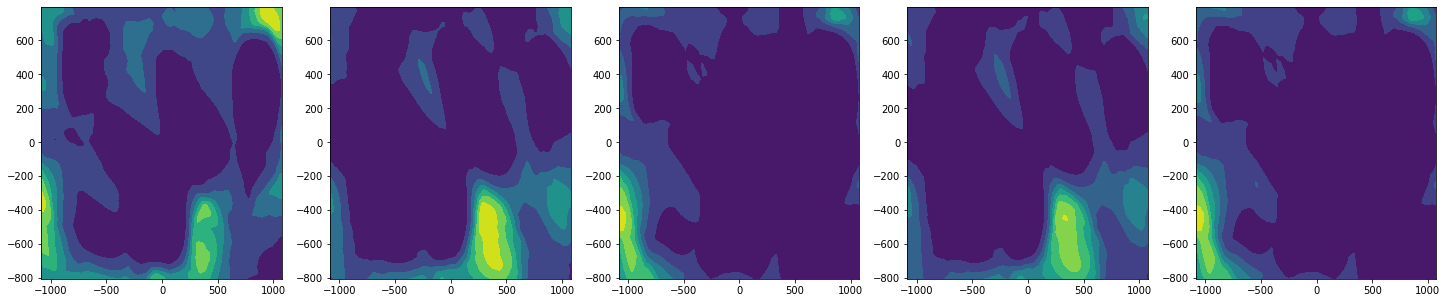

In [5]:
fig, axs = plt.subplots(ncols=N, nrows=1, figsize=(25,5))
X, Y = np.meshgrid(val_set.lidar.xs, val_set.lidar.ys)
xlocs = X[::8, ::8].reshape(-1, 1)
ylocs = Y[::8, ::8].reshape(-1, 1)
val_poses = np.hstack((xlocs, ylocs))

val_inputs = torch.Tensor(val_poses)

for i, ax in enumerate(axs):
    with torch.no_grad():
        pred_dens = models[i].forward(val_inputs)
        ax.tricontourf(xlocs.flatten(), ylocs.flatten(), pred_dens.numpy().flatten())